In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import matplotlib.pyplot as plt
import numpy as np
from epi.models import Parameter, Model
from epi.util import pairplot
import tensorflow as tf
from epi.SC_Circuit_4 import SC_acc, SC_acc_diff, \
    SC_acc_var, SC_sim, \
    SC_sim_opto, unwrap, \
    get_schur_eigs
from scipy.special import expit
from sklearn.linear_model import LinearRegression
import scipy.stats

import os
figdir = "../../written/SC_model/figs/"

c_LP = '#3B8023'
c_LA = '#EA8E4C'
c_RA = '#F4C673'
c_RP = '#81C176'

cmap_g = plt.get_cmap('Greens')
cmap_o = plt.get_cmap('Oranges')


num_plot = 500

### 1. Define the V1Circuit model

In [2]:
lb = -5.
ub = 5.

sW = Parameter("sW", 1, lb=lb, ub=ub)
vW = Parameter("vW", 1, lb=lb, ub=ub)
dW = Parameter("dW", 1, lb=lb, ub=ub)
hW = Parameter("hW", 1, lb=lb, ub=ub)

parameters = [sW, vW, dW, hW]

model = Model("SC_Circuit_var", parameters)

In [4]:
p = 0.75
mu_std = 0.05
model.set_eps(SC_acc_var(p))

epi_df = model.get_epi_df()
epi_df['c0'] = [al_hps['c0'] for al_hps in epi_df['AL_hps']]
epi_df['beta'] = [al_hps['beta'] for al_hps in epi_df['AL_hps']]
epi_df['elemwise_fn'] = ['affine' if 'affine' in path else 'spline' for path in epi_df['path']]
epi_df['random_seed'] = [al_hps['random_seed'] for al_hps in epi_df['arch']]
epi_df['bnmom'] = [al_hps['bn_momentum'] for al_hps in epi_df['arch']]
epi_df['p'] = [ep['mu'][0] for ep in epi_df['EP']]
epi_df['mu_std'] = [np.sqrt(ep['mu'][2]) for ep in epi_df['EP']]
epi_df['mu_len'] = [ep['mu'].shape[0] for ep in epi_df['EP']]

In [6]:
mu =  np.array([p, 1-p, mu_std**2, mu_std**2])
epi_df2 = epi_df[(epi_df['p']==p)
               & (epi_df['beta']==4.)
               & (epi_df['elemwise_fn']=="affine")
               & (epi_df['random_seed'] == 9)]

In [7]:
paths = epi_df2['path'].unique()
best_k = 13
path = paths[0]

In [8]:
_epi_df = epi_df[epi_df['path'] == path]
df_row = _epi_df.iloc[0]
init = df_row['init']
init_params = {"mu":init["mu"], "Sigma":init["Sigma"]}
nf = model._df_row_to_nf(df_row)
aug_lag_hps = model._df_row_to_al_hps(df_row)

dist = model._get_epi_dist(best_k, init_params, nf, mu, aug_lag_hps)

In [10]:
M = 1000
np.random.seed(0)
tf.random.set_seed(0)
z, log_q_z = dist.nf(M)
z, log_q_z = z.numpy(), log_q_z.numpy()
T_x = model.eps(z)
_lb = np.array([p.lb[0] for p in model.parameters])
_ub = np.array([p.ub[0] for p in model.parameters])
z_labels = [p.name for p in model.parameters]
plot_inds = z[:,3] < 6. # keep all
z_plot = z[plot_inds]
log_q_z_plot = log_q_z[plot_inds]
T_x_plot = T_x[plot_inds]


In [8]:
"""z_path_file = np.load('z_path.npz')
z_star = z_path_file['z_stars'][0][None,:]
print(z_star)
def get_hess_path(dist, z0, step=0.15, num_steps=5):
    z = tf.Variable(initial_value=z0, dtype=tf.float32, trainable=True)
    zs = [z0[0]]
    for i in range(num_steps):
        print('step %i' % (i+1))
        hess = dist._hessian(z).numpy()[0]
        if np.sum(np.isnan(hess)) > 0 or np.sum(np.isinf(hess)):
            break
        d, v = np.linalg.eig(hess)
        ind = np.argmin(np.abs(d))
        v_deg = v[:,ind]
        if v_deg[1] > 0.:
            v_deg = -v_deg
        z_next = z + step*v_deg
        z = tf.Variable(initial_value=z_next, 
                        dtype=tf.float32, trainable=True)
        zs.append(z_next.numpy()[0])
    return np.array(zs)

step = 0.1
num_steps = 45
z_path = get_hess_path(dist, z_star, step=step, num_steps=num_steps)"""
z_path_file = np.load('z_path.npz')
z_path = z_path_file['z_stars']
T_x_path = model.eps(z_path)

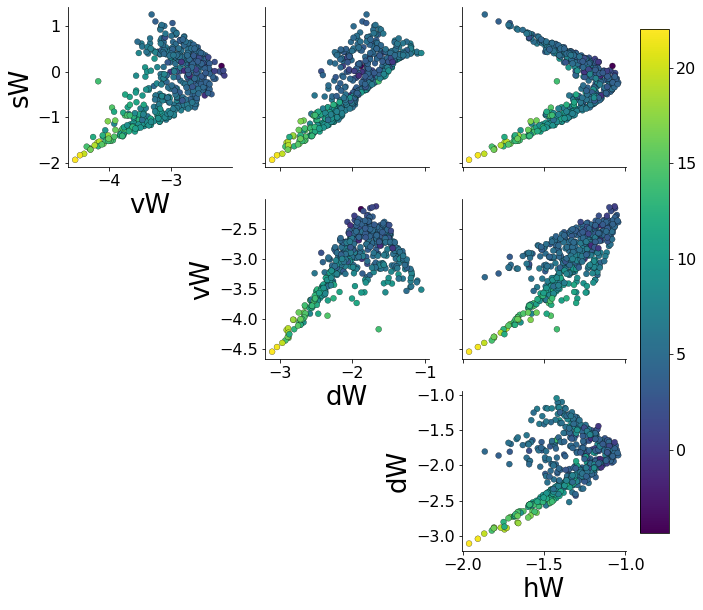

In [11]:
fig = pairplot(z_plot[:num_plot], np.arange(4), z_labels,
               fontsize=26, figsize=(10,10), ticksize=16, s=35,
               c=log_q_z_plot[:num_plot])

In [12]:
T_x_plot = SC_acc(*unwrap(z_plot)).numpy()
def z_to_W(z):
    sW = z[:,0]
    vW = z[:,1]
    dW = z[:,2]
    hW = z[:,3]

    Wrow1 = tf.stack([sW, vW, dW, hW], axis=1)
    Wrow2 = tf.stack([vW, sW, hW, dW], axis=1)
    Wrow3 = tf.stack([dW, hW, sW, vW], axis=1)
    Wrow4 = tf.stack([hW, dW, vW, sW], axis=1)

    W = tf.stack([Wrow1, Wrow2, Wrow3, Wrow4], axis=1)
    
    return W

    
W = z_to_W(z_plot)
pP = T_x_plot[:,0]
pA = 1. - T_x_plot[:,1]

NameError: name 'eigs' is not defined

In [99]:
"""_inds = np.argsort(-eigs[:,3])
P_inds = np.argsort(np.abs(pP-.85))
A_inds = np.argsort(np.abs(pA-.85))
z_stars = z_plot[P_inds[[0,3]],:]
z_stars = np.concatenate((z_stars, z_plot[[A_inds[1], _inds[30]],:]), axis=0)
z_star_inds = [P_inds[0], P_inds[3], A_inds[1], _inds[30]]
print(z_star_inds)
W_stars = z_to_W(z_stars)"""

[624, 467, 516, 492]


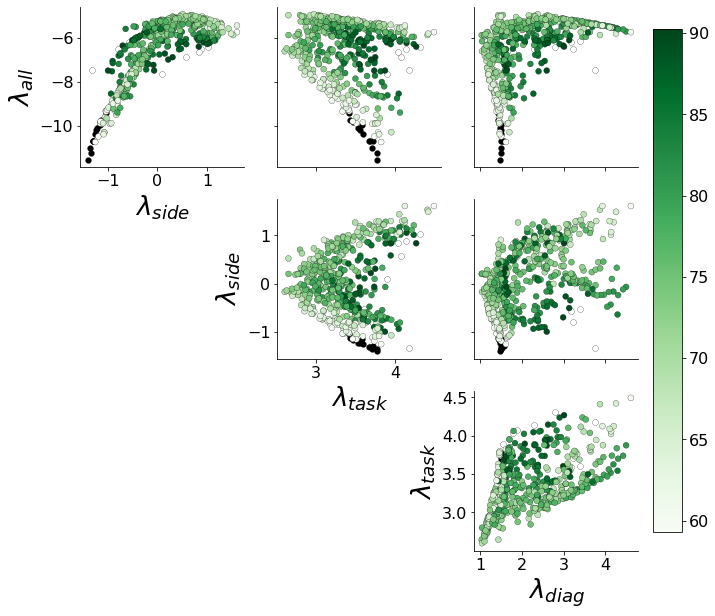

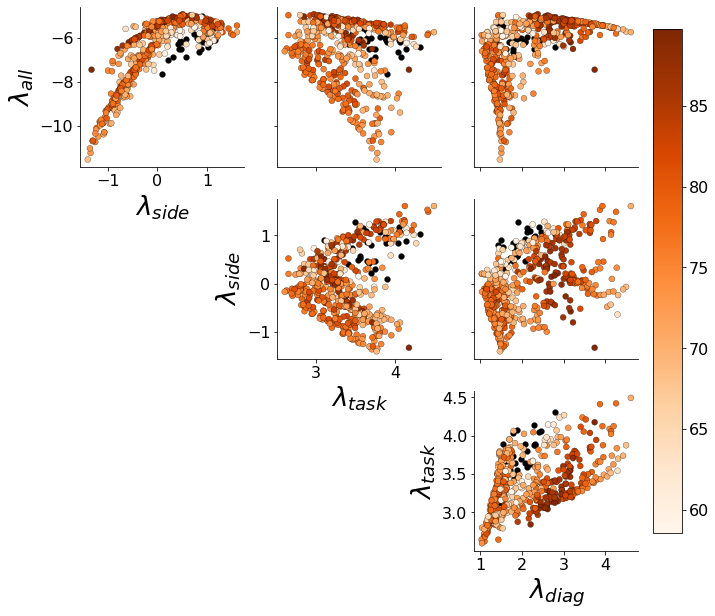

In [14]:
ylabels = [r'$p_P$ (%)', r'$p_A$ (%)']

eigs = np.array([get_schur_eigs(W[i]) for i in range(pP.shape[0])])
#eigs_stars = np.array([get_schur_eigs(W_stars[i]) for i in range(W_stars.shape[0])])
    
eig_names = ['all', 'side', 'task', 'diag']
eig_labels = [r'$\lambda_{%s}$' % eig_name for eig_name in eig_names]

"""fig = pairplot(eigs[:num_plot], np.arange(4), eig_labels, 
               outlier_stds=2, starred=eigs_stars, c_starred=2*['k'],
               fontsize=26, figsize=(10,10), ticksize=16, s=35, c=log_q_z_plot[:num_plot])"""

fig = pairplot(eigs[:num_plot], np.arange(4), eig_labels, 
               outlier_stds=2, #starred=eigs_stars, c_starred=['b', 'r', 'g', 'k'],
               fontsize=26, figsize=(10,10), ticksize=16, s=35, c=100*pP, cmap=cmap_g)

fig = pairplot(eigs[:num_plot], np.arange(4), eig_labels, cmap=cmap_o, 
               outlier_stds=2, #starred=eigs_stars, c_starred=['b', 'r', 'g', 'k'],
               fontsize=26, figsize=(10,10), ticksize=16, s=35, c=100*pA)
#plt.savefig(os.path.join(figdir, "SC_EPI_pA.png"))

85.0, 73.6


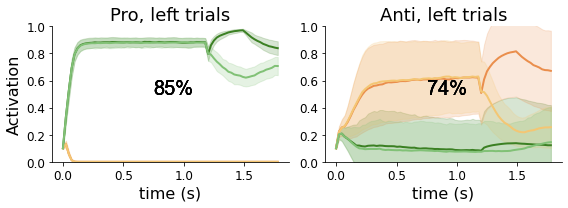

84.9, 75.7


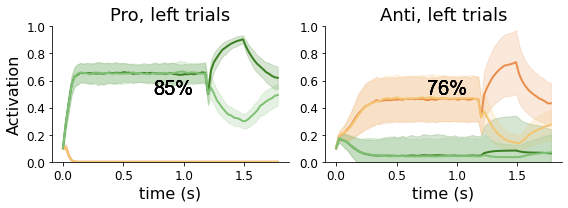

68.7, 85.1


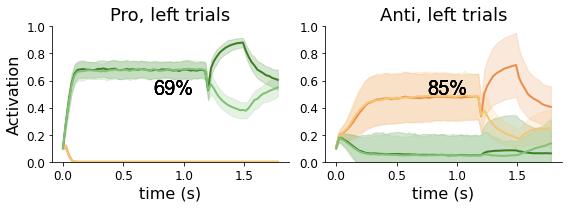

83.5, 79.6


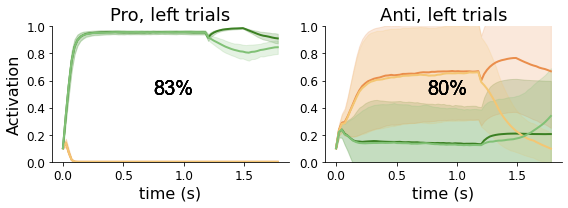

In [101]:
u_t, v_t = SC_sim(*unwrap(z))
v_t_plot = v_t.numpy()[:,plot_inds]
u_t_plot = u_t.numpy()[:,plot_inds]

v_t_stars = np.stack([v_t_plot[:,ind,:,:,:] for ind in z_star_inds], axis=1)
T_x_stars = np.stack([T_x_plot[ind,:] for ind in z_star_inds], axis=0)

t_cue_delay = 1.2
t_choice = 0.3
t_post_choice = 0.3
t_total = t_cue_delay + t_choice + t_post_choice
dt = 0.024
t = np.arange(0.0, t_total, dt)
T = t.shape[0]

percfont = {'family': 'arial',
            'weight': 'light',
            'size': 20,
        }
neuron_labels = ['LP', 'LA', 'RA', 'RP']
colors = [c_LP, c_LA, c_RA, c_RP]
C_titles = ['Pro, left trials', 'Anti, left trials']
for m in range(len(z_stars)):
    print("%.1f, %.1f" % (100*T_x_stars[m,0], 100-100*T_x_stars[m,1]))
    fig, axs = plt.subplots(1,2,figsize=(8, 3))
    for c in range(2):
        for i in range(4):
            mean_v = np.mean(v_t_stars[:,m,c,i,:], axis=1)
            std_v = np.std(v_t_stars[:,m,c,i,:], axis=1)
            axs[c].fill_between(t, mean_v - std_v, mean_v + std_v, color=colors[i], alpha=0.2)
            axs[c].plot(t, mean_v, label=neuron_labels[i], c=colors[i])
            axs[c].set_title(C_titles[c])
            axs[c].set_ylim([0,1])
            if c == 0:
                axs[c].text(0.75, 0.5, '%2d%%' % round(100.*T_x_stars[m,c]), fontdict=percfont)
            else:
                axs[c].text(0.75, 0.5, '%2d%%' % round(100.*(1.-T_x_stars[m,c])), fontdict=percfont)
        axs[c].set_xlabel('time (s)')
    axs[0].set_ylabel('Activation')
        
    plt.tight_layout()
    #plt.savefig(os.path.join(figdir, "sim%d.pdf" % (m+1)))
    plt.show()

In [62]:
strength = 0.2
sc_acc_diff = SC_acc_diff(strength, 'delay')
diffs = sc_acc_diff(*unwrap(z_path)).numpy()
diffs[:,1] = -diffs[:,1]

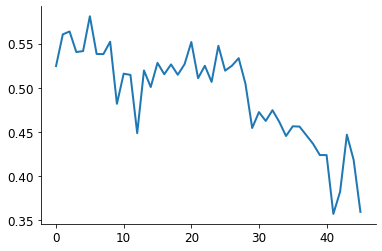

In [63]:
plt.plot(diffs[:,1])

In [15]:
strength = 0.2
sc_acc_diff = SC_acc_diff(strength, 'delay')
diffs = sc_acc_diff(*unwrap(z_plot)).numpy()
diffs[:,1] = -diffs[:,1]

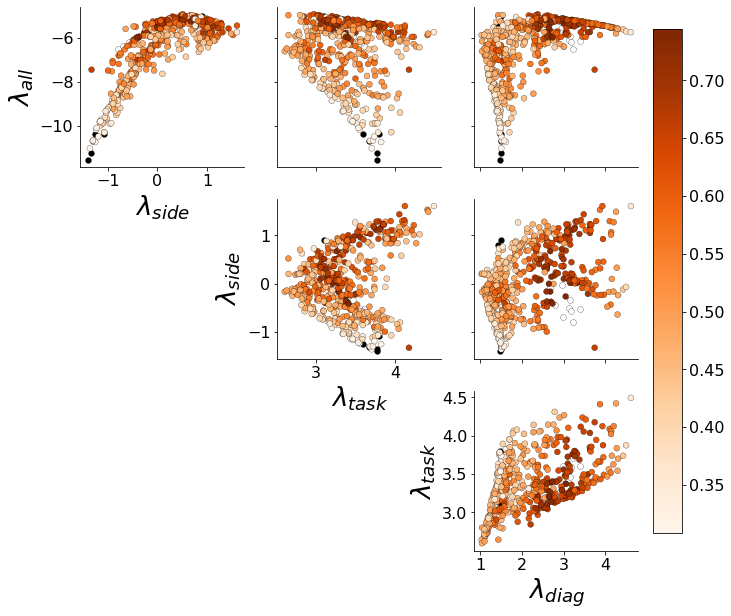

In [16]:
fig = pairplot(eigs[:num_plot], np.arange(4), eig_labels, cmap=cmap_o, outlier_stds=2,
               #traj=eigs_path,
               fontsize=26, figsize=(10,10), ticksize=16, s=35, c=diffs[:,1])

In [17]:
y_labels = [r'$p_P-p_{P,opto}$ (%)', r'$p_A-p_{A,opto}$ (%)']
tasks = ['P', 'A']
ylims = [[-7.5, 7.5], [0, 75]]
for j in range(2):
    ylim = ylims[j]
    for i, eig_name in enumerate(eig_names):
        if i==0:
            y_label = y_labels[j]
        else:
            y_label = ""
        plot_corr(eigs[:,i], r'$\lambda_{%s}$' % eig_name, 
                    100*diffs[:,j], y_label, ylim=ylim,
                    s=5, num_plot=500, fontsize=26)
        plt.tight_layout()
        #plt.savefig(os.path.join(figdir, "lambda_opto_%s_%s.pdf" % (eig_name, tasks[j])), 
        #            transparent=True)

NameError: name 'plot_corr' is not defined

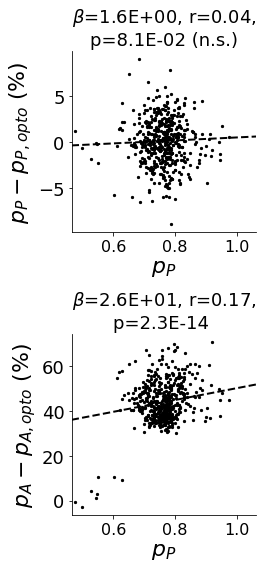

In [66]:
ylabels = [r'$p_P-p_{P,opto}$ (%)', r'$p_A-p_{A,opto}$ (%)']
plot_2corrs(pP, r'$p_P$', 100*diffs[:,0], 100*diffs[:,1], ylabels, 
             alignment='v', s=5, num_plot=500, fontsize=22)
plt.tight_layout()
#plt.savefig(os.path.join(figdir, "pP_opto.pdf"))

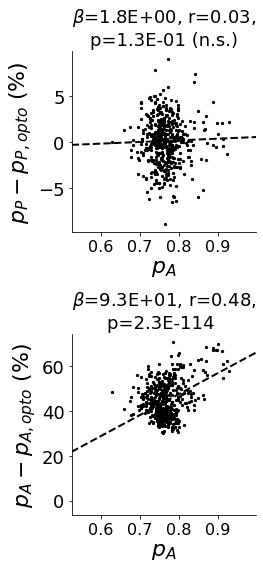

In [67]:
plot_2corrs(pA, r'$p_A$', 100*diffs[:,0], 100*diffs[:,1], ylabels,
             alignment='v', s=5, num_plot=500, fontsize=22)
plt.tight_layout()
#plt.savefig(os.path.join(figdir, "pA_opto.pdf"))

In [63]:
periods = ['delay', 'choice', 'total']
strengths = np.linspace(0., 1., 21)
diffs = []
approx_num = 100

for period in periods:
    _diffs = []
    for strength in strengths:
        print(period, strength)
        sc_acc_diff = SC_acc_diff(strength, period)
        _diff = sc_acc_diff(*unwrap(z_plot[:approx_num])).numpy()
        _diff[:,1] = -_diff[:,1]
        _diffs.append(_diff)
    diffs.append(np.array(_diffs))

delay 0.0
delay 0.05
delay 0.1
delay 0.15000000000000002
delay 0.2
delay 0.25
delay 0.30000000000000004
delay 0.35000000000000003
delay 0.4
delay 0.45
delay 0.5
delay 0.55
delay 0.6000000000000001
delay 0.65
delay 0.7000000000000001
delay 0.75
delay 0.8
delay 0.8500000000000001
delay 0.9
delay 0.9500000000000001
delay 1.0
choice 0.0
choice 0.05
choice 0.1
choice 0.15000000000000002
choice 0.2
choice 0.25
choice 0.30000000000000004
choice 0.35000000000000003
choice 0.4
choice 0.45
choice 0.5
choice 0.55
choice 0.6000000000000001
choice 0.65
choice 0.7000000000000001
choice 0.75
choice 0.8
choice 0.8500000000000001
choice 0.9
choice 0.9500000000000001
choice 1.0
total 0.0
total 0.05
total 0.1
total 0.15000000000000002
total 0.2
total 0.25
total 0.30000000000000004
total 0.35000000000000003
total 0.4
total 0.45
total 0.5
total 0.55
total 0.6000000000000001
total 0.65
total 0.7000000000000001
total 0.75
total 0.8
total 0.8500000000000001
total 0.9
total 0.9500000000000001
total 1.0


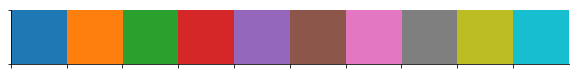

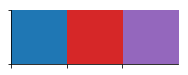

In [64]:
import seaborn as sns
pal = sns.color_palette()
sns.palplot(pal)
opto_colors = [pal[i] for i in [0, 3, 4]]
sns.palplot(opto_colors)

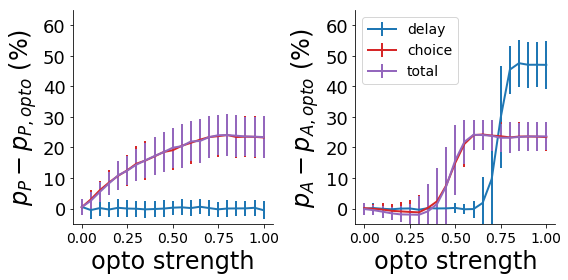

In [70]:
fig, axs = plt.subplots(1,2,figsize=(8,4))
for i, period in enumerate(periods):
    diff_mean = np.mean(100.*diffs[i], axis=1)
    diff_std = np.std(100.*diffs[i], axis=1)
    for j in range(2):
        axs[j].errorbar(1.-strengths, diff_mean[:,j], diff_std[:,j],
                        c=opto_colors[i], label=period)

fontsize = 24
ticksize = fontsize-10
for j in range(2):
    axs[j].set_xlabel('opto strength', fontsize=fontsize)
    axs[j].set_ylabel(ylabels[j], fontsize=fontsize)
    axs[j].set_ylim([-5, 65])
    plt.setp(axs[j].get_xticklabels(), fontsize=ticksize)
    plt.setp(axs[j].get_yticklabels(), fontsize=(ticksize+4))
axs[1].legend(fontsize=ticksize)
plt.tight_layout()
plt.savefig(os.path.join(figdir, "opto_effects.pdf"))